In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(520, IMG_SIZE)

In [2]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 14, dtype=torch.float32)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Let's look at the test image: some basic shapes with some patterning. Notably some of the features are smaller than the 14x14 patch size. Let's also visualise the shifting data prep the network does, by shifting by a large amount (70px) and plotting. We'll also save it to use in a diagram later.

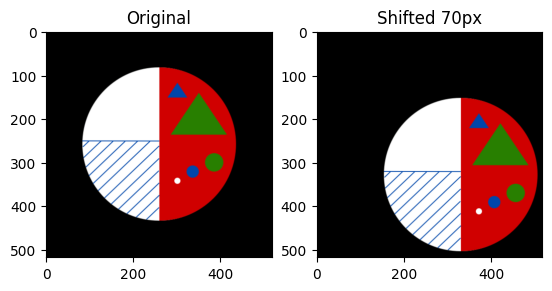

In [3]:
test_tensor, test_img = tr.load_image("data/test_image_centred.png", transform)
test_tensor = test_tensor.to('cuda')

SHIFT = 70
fwd_shifts, inv_shifts = tr.get_shift_transforms([SHIFT], 'Moore')
shifted_img_tensors = net.get_transformed_input_batch(test_tensor, fwd_shifts).detach().cpu()
shifted_img: Image.Image = tr.to_img(tr.unnormalize(shifted_img_tensors[-1, :, :, :]))


fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].imshow(test_img)
axs[0].set_title("Original")

axs[1].imshow(shifted_img)
axs[1].set_title(f"Shifted {SHIFT}px")

shifted_img.save("out/shifted_input.png")

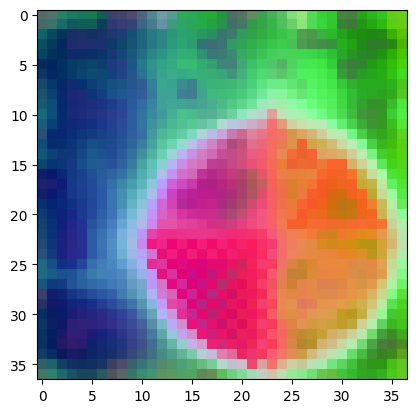

In [4]:
# Get low res features of the final shifted image (this is just a call to vanilla DINOv2, so we need to batch)
shift_img_tensor = shifted_img_tensors[-1].unsqueeze(0).cuda()
low_res_feature_batch = net.get_dv2_features(shift_img_tensor, 14)
low_res_feature_arr = tr.to_numpy(low_res_feature_batch)

shifted_features = do_single_pca(low_res_feature_arr)
# rescale between 0 and 1 for plotting
rescaled_shifted_features = rescale_pca(shifted_features)
rescaled_shifted_feat_img = rescaled_shifted_features.reshape(PATCH_H, PATCH_W, 3)
plt.imshow(rescaled_shifted_feat_img)
plt.imsave("out/shifted_features_lr.png" ,rescaled_shifted_feat_img)

In [5]:
shift_dists = [i for i in range(1, 7)]
transforms, inv_transforms = tr.get_shift_transforms(shift_dists, 'Moore')
net.set_transforms(transforms, inv_transforms)
high_res_features, low_res_features = net(test_tensor)

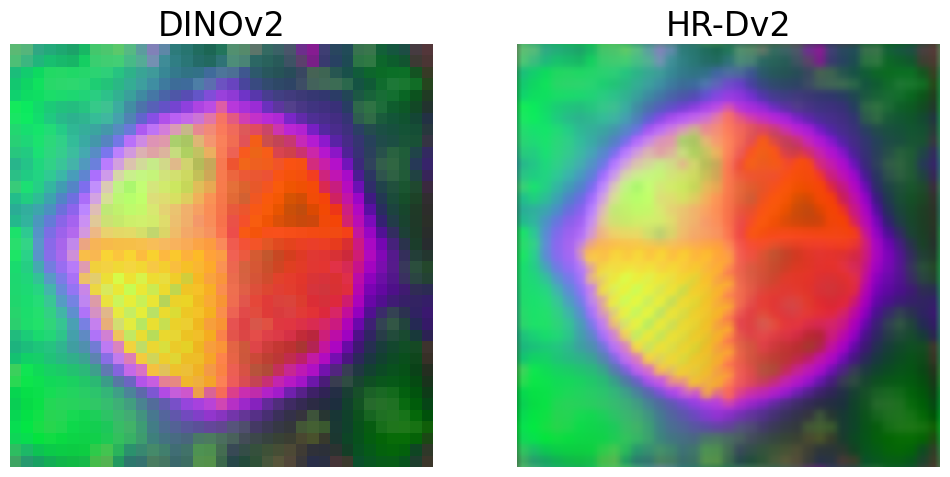

In [6]:
feat_arr_hr, feat_arr_lr = tr.to_numpy(high_res_features), tr.to_numpy(low_res_features)
feat_arr_hr = feat_arr_hr.reshape((net.feat_dim, IMG_SIZE * IMG_SIZE))
feat_arr_hr = feat_arr_hr.T

fig, axs = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(12, 6)
titles = ["DINOv2", "HR-Dv2"]

pcas: List[np.ndarray] = []
features = [feat_arr_lr, feat_arr_hr]
i = 0
for arr, shapes in zip(features, [(PATCH_H, PATCH_W, 3), (IMG_SIZE, IMG_SIZE, 3)]):
    feat_pca = do_single_pca(arr)
    rescale_feat_pca = rescale_pca(feat_pca)
    pcas.append(feat_pca)

    ax = axs[i]
    ax.imshow(rescale_feat_pca.reshape(shapes)[:, :, :])
    ax.set_title(titles[i], fontsize=24)
    ax.set_axis_off()
    i += 1 

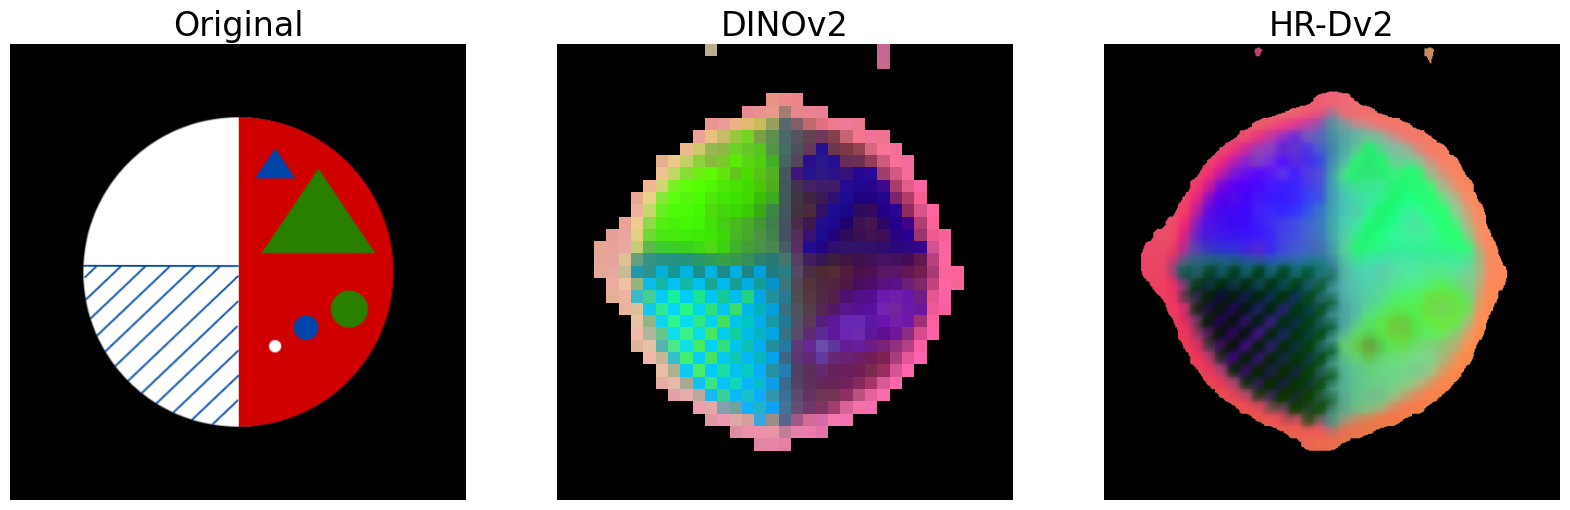

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 12)
titles = ["DINOv2", "HR-Dv2"]
# Show original image
axs[0].imshow(test_img)
axs[0].set_title("Original", fontsize=24)
axs[0].set_axis_off()

i = 0
for pca, shapes in zip(pcas, [(PATCH_H, PATCH_W, 3), (IMG_SIZE, IMG_SIZE, 3)]):
    feat = features[i]
    # Threshold the features by seeing where the 1st component of their (normalised) PCA > 0
    fg_features, fg_pca, fg_mask = threshold_pca(feat, pca, 0, True, True)
    # Compute a new PCA on *only the foreground features* separately for low and high res
    fg_pca = do_single_pca(fg_features)
    rescale_fg_pca = rescale_pca(fg_pca)

    # Loop over every value in fg_mask, where it is 1, set out to be that feature from fg pca, otherwise set to 0
    out = np.zeros((shapes[0] * shapes[1], shapes[2]))
    nonzero_idx = 0
    for j, val in enumerate(fg_mask):
        if val == 1:
            out[j, :] = rescale_fg_pca[nonzero_idx, :]
            nonzero_idx += 1

    ax = axs[i + 1]
    ax.imshow(out.reshape(shapes))
    ax.set_title(titles[i], fontsize=24)
    ax.set_axis_off()
    i += 1 

We're looking at the PCA of only the foreground features of each feature map (low- and high- res). We can see the high res has greater spatial resolution (i.e more success in capturing edges, lines *etc.*). Note that it doesn't seem to like large regions with flat colours like the upper left quadrant of the circle or the centre of the large triangle, and seems to think they could be background.

In [8]:
net.set_model_stride(net.dinov2, 4)

Setting stride to (4,4)


In [9]:
net.set_transforms([], [])
ve_features, _ = net.forward(test_tensor)

Setting stride to (14,14)
Setting stride to (4,4)


In [10]:
ve_features = tr.to_numpy(ve_features)
ve_features = ve_features.reshape((net.feat_dim, IMG_SIZE * IMG_SIZE))
ve_features = ve_features.T

ve_pca = do_single_pca(ve_features, 3)
ve_rescaled_pca = rescale_pca(ve_pca)

In [11]:
shift_dists = [i for i in range(1, 3)]
transforms, inv_transforms = tr.get_shift_transforms(shift_dists, 'Moore')
net.set_transforms(transforms, inv_transforms)
hy_features, lr_features = net.forward_sequential(test_tensor)

Setting stride to (14,14)
Setting stride to (4,4)


In [12]:
hy_features, lr_features = tr.to_numpy(hy_features), tr.to_numpy(lr_features)
hy_features = hy_features.reshape((net.feat_dim, IMG_SIZE * IMG_SIZE))
hy_features = hy_features.T

hy_pca = do_single_pca(hy_features, 3)
hy_rescaled_pca = rescale_pca(hy_pca)

lr_pca = do_single_pca(lr_features, 3)
lr_rescaled_pca = rescale_pca(lr_pca)

n_patch_h, n_patch_w = net.get_n_patches(IMG_SIZE, IMG_SIZE)

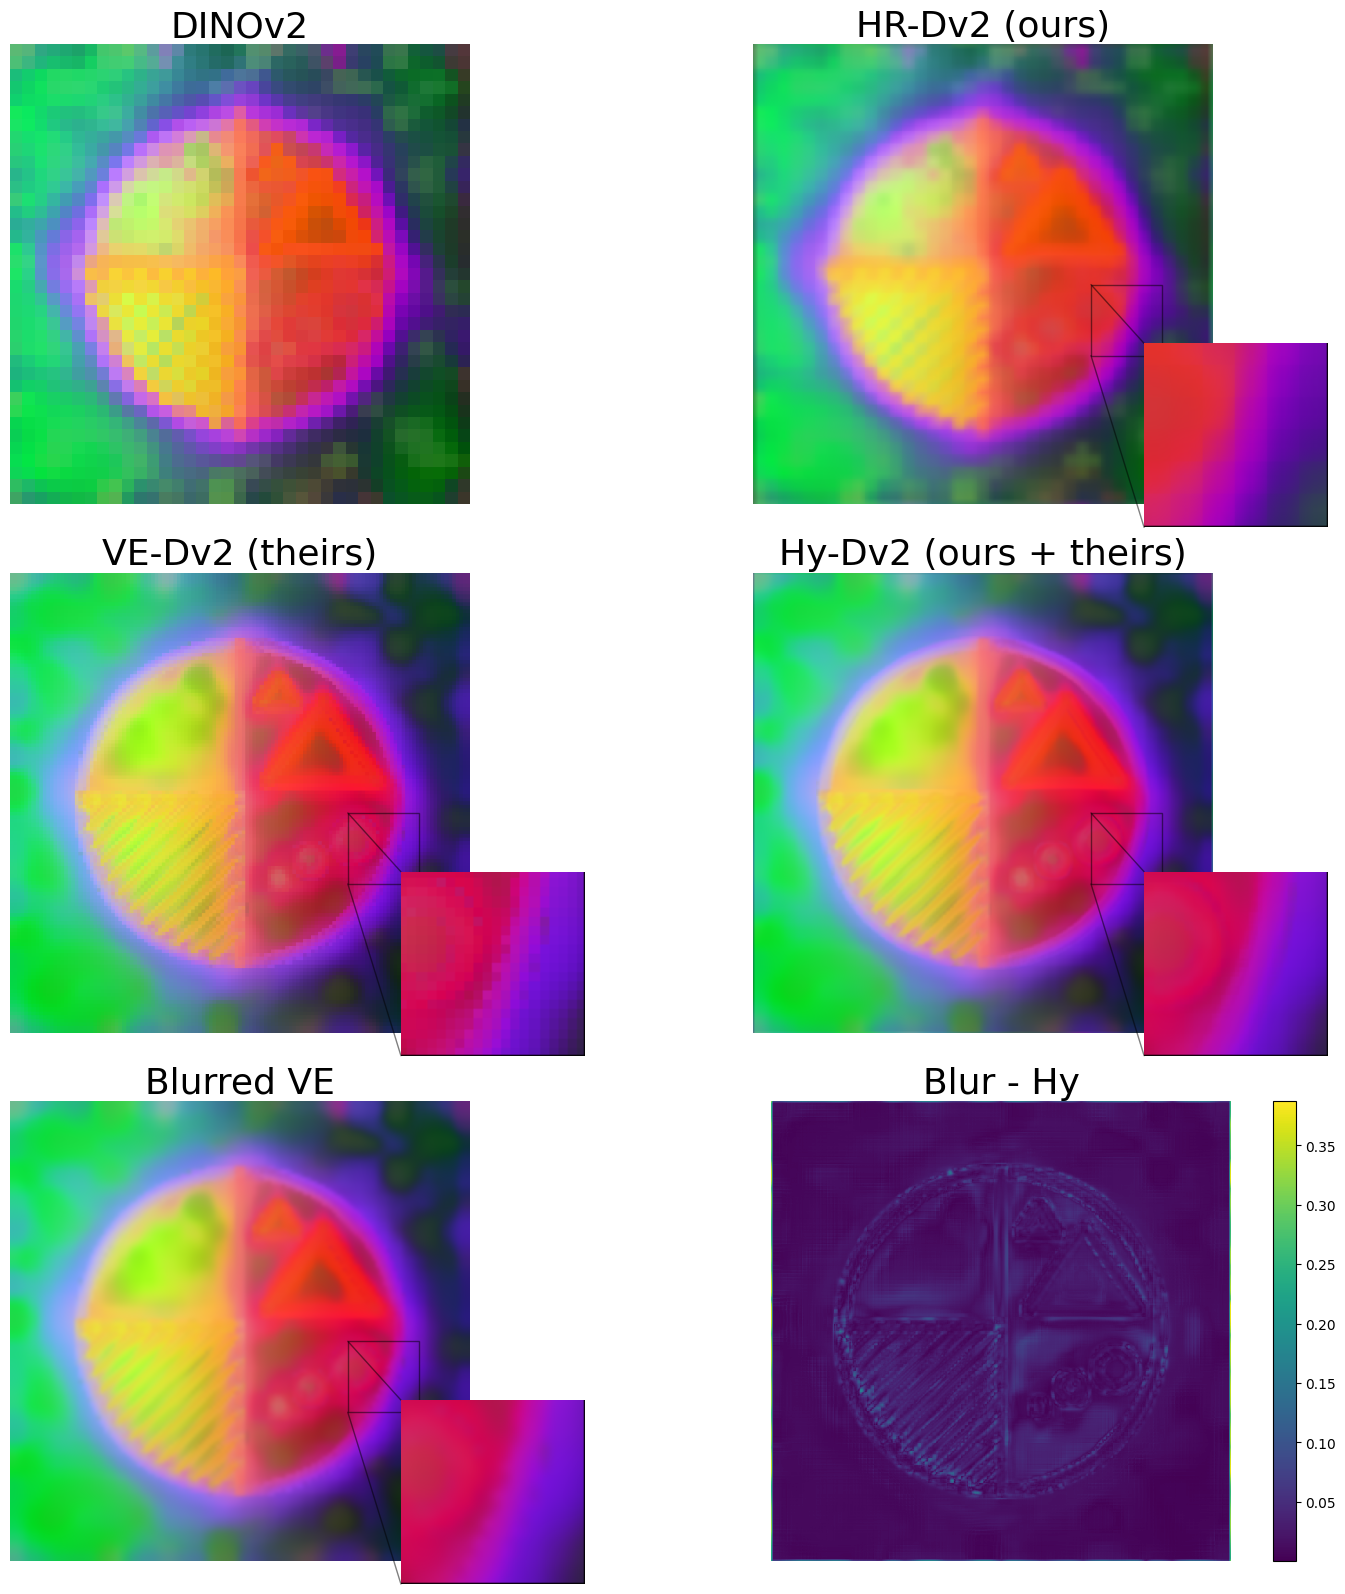

In [13]:
from skimage.filters import gaussian

fig, axs = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(16, 16)
titles = ["DINOv2", "HR-Dv2 (ours)", "VE-Dv2 (theirs)", "Hy-Dv2 (ours + theirs)", "Blurred VE", "Blur - Hy"]
new_pcas = [lr_pca, pcas[1], ve_pca, hy_pca, ve_pca, hy_pca]
new_shapes = [(PATCH_H, PATCH_W, 3)] + [(IMG_SIZE, IMG_SIZE, 3) for i in range(5)]
# Show original image
compare = None

i = 0
for pca, shapes in zip(new_pcas, new_shapes):
    rescaled_pca = rescale_pca(pca)
    reshaped = rescaled_pca.reshape(shapes)
    ax = axs[i // 2 , i % 2]

    if i == 4:
        reshaped = gaussian(reshaped, sigma=(2, 2, 0))
        compare = reshaped
    if i == 5:
        reshaped = np.sum(np.abs(reshaped - compare), axis=2).reshape((shapes[0], shapes[1], 1)) 

    im = ax.imshow(reshaped)
    ax.set_title(titles[i], fontsize=26)
    ax.set_axis_off()

    if 0 < i < 5:
        x0, y0, w, h = [380, 270, 80, 80]
        inset_data = np.zeros_like(reshaped)
        inset_data[y0:y0+h, x0:x0+w, :] = reshaped[y0:y0+h, x0:x0+w, :]
        extent = (0, IMG_SIZE, IMG_SIZE, 0)
        # 418 / 518, 0 / 518, 150 / 518, 150 / 518
        axin = ax.inset_axes(
            [0.85, -0.05, 0.4, 0.4], xlim=(x0, x0+w), ylim=(y0, y0+h))
        axin.set_axis_off()
        axin.imshow(inset_data)
        ax.indicate_inset_zoom(axin, edgecolor="black")
        axin.set_ylim((y0 + h, y0))
    
    if i == 5:
        fig.colorbar(im, ax=ax)
        #ax.show_colorbar()
    i += 1

plt.tight_layout()
#plt.subplots_adjust(wspace=0)